# Upper vs. Lower-Tercile State Comparison 

##### Supplementary code for Faletti et al. (2026): _Using Ensemble Sensitivity to Diagnose Environmental Modulation of Mesocyclone Intensity in the Warn-on-Forecast System_

### Reproduces Fig. S5b,c

In [1]:
# Import basic libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import datetime
import xarray as xr
import pandas as pd

# Import authored modules
import centered_response as cr
from wofunits import wofunits
from wofs_colortables import cb_colors

# To suppress warnings
import logging

# set file paths
wofs_path = wofunits.paths['wofs_path'] # WoFS data path
sens_path = wofunits.paths['sens_path'] # sensitivity data path
sm_path = wofunits.paths['sm_path'] # storm motion CSV path
outplot_path = wofunits.paths['outplot_path'] # plot save path

## Manually set case, time, etc. for the desired plotting

In [2]:
# Select case
#case = '201905172200'
case = '201905202030'
#case = '201905262000'
#case = '201905282230'

# save plot?
save = False

# set sensitivity specs
valid_time = datetime.datetime(2019,5,20,22,0)
statevar = 'MLCAPE'
respvar = 'UH25_30MIN'


### Plotting specs ###
# x/y axis limits
xlimleft, xlimright = -40,60
ylimleft, ylimright = -60,50

levels = np.arange(-60,61,5) # sensitivity contour levels
ticks = levels[0::4] # colorbar ticks

# axis labels
axlabels = ['b)','c)']

# Set upper- and lower-terciles
upp_terc = wofunits.rankidx[case][respvar][:12]
low_terc = wofunits.rankidx[case][respvar][24:]

## Plot Fig. S5b,c: Upper- vs. Lower-Tercile State Comparison

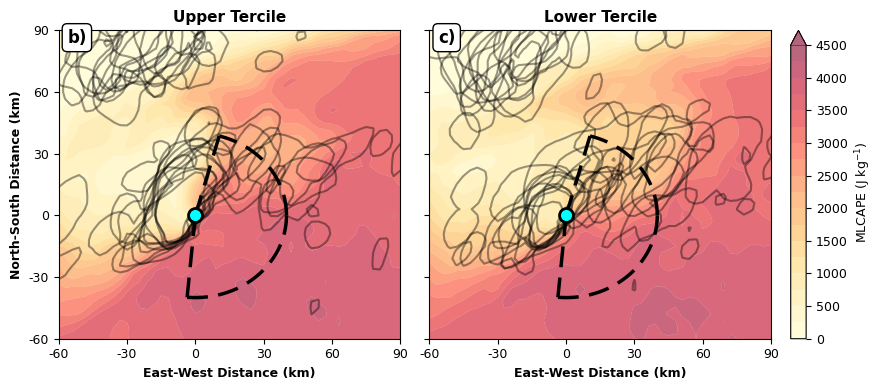

In [3]:

wofs_casedir, file_latlons, file_coords, file_resp_coords, file_mrms_maxima, files_wofs, state_times, resptime = cr.case_sel(case)

################################# Define inflow domain specs ##########################################

ang_bound1, ang_bound2 = 40, 230 # angular domain bounds relative to the storm motion

# open storm motion csv files
sm_x = pd.read_csv(f'{sm_path}/{case}_motions_nx.csv', index_col='Member')
sm_y = pd.read_csv(f'{sm_path}/{case}_motions_ny.csv', index_col='Member')

    # average storm motion components at chosen time
sm_mean_x = np.nanmean(sm_x.iloc[:-1][str(valid_time)].values)
sm_mean_y = np.nanmean(sm_y.iloc[:-1][str(valid_time)].values)

    # calculate angle of storm motion relative to positive x-axis
storm_ang = cr.calc_storm_ang(sm_mean_x, sm_mean_y)

################################# Define figure and plot ##########################################

fig, axs = plt.subplots(1, 2,figsize=(9,4))
axs = axs.flatten()

state_time = state_times[-3]

for i, ax in enumerate(axs):

    ############### Process date/time strings and define file names ################
    
    str_statemin, str_statehour, str_statemonth = '{:02d}'.format(state_time.minute),'{:02d}'.format(state_time.hour),'{:02d}'.format(state_time.month)
    inityear, initmin, inithour, initday, initmonth = case[0:4], case[10:12], case[8:10], case[6:8], case[4:6]
    
    file_ref = f'{wofs_path}/wofs_{inityear}{initmonth}{initday}_{inithour}{initmin}/wofs_center_i{inityear}{initmonth}{initday}{inithour}{initmin}_v{state_time.year}{str_statemonth}{state_time.day}{str_statehour}{str_statemin}.nc'
        
    ############### Open files and define variables from them ################
    
    ds_ref = xr.open_dataset(file_ref)

    cref_upp = np.where(ds_ref.REFD_MAX[upp_terc] < 10, np.nan, ds_ref.REFD_MAX[upp_terc])
    cref_low = np.where(ds_ref.REFD_MAX[low_terc] < 10, np.nan, ds_ref.REFD_MAX[low_terc])

    cape_upp = np.nanmean(ds_ref.MLCAPE[upp_terc], axis=0)[0]
    cape_low = np.nanmean(ds_ref.MLCAPE[low_terc], axis=0)[0]
    
    ############### Define storm-relative grids ################
    
    logging.captureWarnings(True) # capture warnings 
    
    df_center = cr.create_mrmscenter_df(file_coords, file_mrms_maxima)
    
    xmesh,ymesh = cr.xy_mesh(case, state_time)
    
    logging.captureWarnings(False) # turn warnings back on
    
    ############### Plotting code ################

    if i == 0:
        cref = cref_upp
        cape = cape_upp
    else:
        cref = cref_low
        cape = cape_low
        
    #cb = ax.contourf(xmesh, ymesh, cref, cmap=cr.cref_cmap(), levels=np.arange(20,71,5), extend='max', alpha=1)
        
    #ax.contourf(xmesh, ymesh, cref, linewidths=2, levels=[20,35,50], colors='k')
    cb = ax.contourf(xmesh, ymesh, cape, cmap='YlOrRd', extend='max', levels=np.arange(0,4501,250), 
                antialiased=True, alpha=0.6) 
    
    for j in range(12):
        color = colors.rgb2hex(cb_colors.paintball_colors.colors[j])
        #ax.contour(xmesh, ymesh, cref[j,0], linewidths=3, levels=[50], colors='w', alpha=1)
        ax.contour(xmesh, ymesh, cref[j,0], linewidths=1.5, levels=[45], colors='k', alpha=0.4)
    
    cr.plot_domain(storm_ang = storm_ang, if_region='nf',
            ang_bounds = (ang_bound1, ang_bound2), dashes=(6,3), lw=2.5, subplot=True, ax=ax)
    ax.scatter(0,0, marker='o', s=100, lw=2, edgecolor='k', facecolor='aqua', zorder=999)
    
    #cb = ax.contourf(xmesh, ymesh, sens, cmap='RdBu_r', levels=levels, extend='both', antialiased=True, alpha=0.5)
    #ax.contourf(xmesh, ymesh, pstat, [0, 0.05], colors='none', hatches=['\\\\\\\\'], extend='lower')
    
    #ax.set_facecolor('darkgrey') # make axis background gray
    
    ax.set_xlim(-60,90)
    ax.set_ylim(-60,90)
    
    ########## Axis decoration specs ##########
    
    xticks, yticks = np.arange(-60,91,30), np.arange(-60,91,30)
    
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    
    ax.set_xlabel('East-West Distance (km)', size=9, weight='bold')
    ax.set_xticklabels(xticks, size=9)
    
    if i == 0:
        ax.set_ylabel('North-South Distance (km)', size=9, weight='bold')
        ax.set_yticklabels(yticks, size=9)
    if i == 1:
        ax.set_yticklabels([])
    
    if i == 0:
        ax.set_title(f'Upper Tercile', size=11, weight='bold')
    if i == 1:
        ax.set_title(f'Lower Tercile', size=11, weight='bold')
    
    ax.text(0.025, 0.96, axlabels[i], color='k',
        bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax.transAxes, 
        size=12, weight='bold')

    ########## Colorbar specs ##########

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.tight_layout() # make sure tight_layout() comes before defining colorbar

cbar = fig.colorbar(cb, ax=axs, orientation='vertical', fraction=.1, pad=0.024)
cbar.set_label(label=f'''{statevar} ({wofunits.labels[statevar]})''', size=9)
cbar.ax.tick_params(labelsize=9)

    ########## Save statement ##########

if save == True:
    plt.savefig(f'{outplot_path}/tercs_mlcape_{case}.jpg', bbox_inches='tight', facecolor='w', dpi = 200)

plt.show()